Starting training...
Iteration 50/300, Total Loss: 44.652040, PDE Loss: 44.507179, BC Loss: 1.448606
Iteration 100/300, Total Loss: 3.652080, PDE Loss: 3.643593, BC Loss: 0.084870
Iteration 150/300, Total Loss: 0.019933, PDE Loss: 0.019888, BC Loss: 0.000445
Iteration 200/300, Total Loss: 0.000141, PDE Loss: 0.000141, BC Loss: 0.000002
Iteration 250/300, Total Loss: 0.000048, PDE Loss: 0.000048, BC Loss: 0.000000
Iteration 300/300, Total Loss: 0.000048, PDE Loss: 0.000048, BC Loss: 0.000000
Training finished.


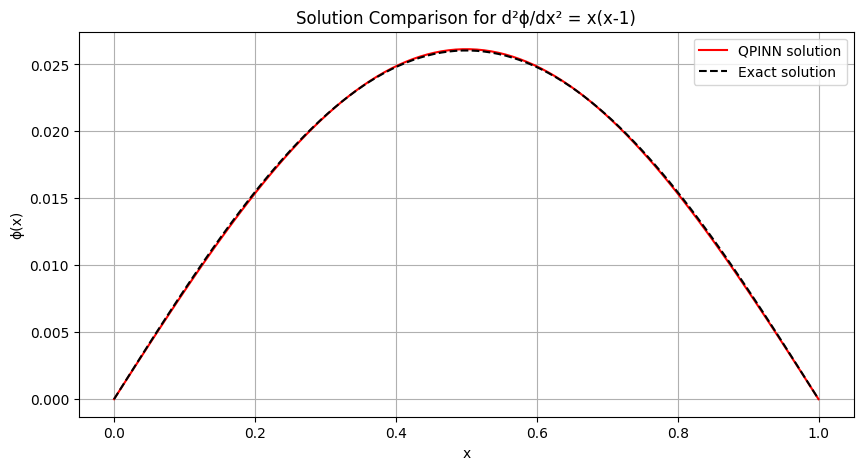

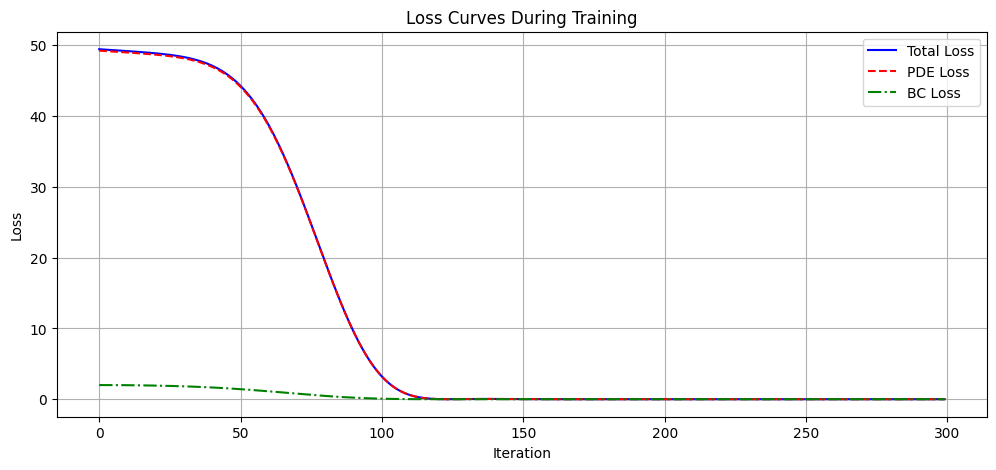

In [12]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# Hyperparameters
# ----------------------------------------------------------
num_qubits = 1               # Number of qubits in the quantum circuit
num_layers = 3               # Number of variational layers
learning_rate = 0.01         # Learning rate for the optimizer
num_iterations = 300        # Number of training iterations
n_points = 100                # Number of training points in [0,1]

# ----------------------------------------------------------
# Create PennyLane device
# ----------------------------------------------------------
# Specify diff_method="backprop" to use PyTorch backpropagation
dev = qml.device("default.qubit", wires=num_qubits)

# ----------------------------------------------------------
# Quantum Circuit Definition
# ----------------------------------------------------------
@qml.qnode(dev, interface="torch", diff_method="backprop")
def quantum_model(params, x):
    """
    This QNode encodes the input x using a single RX rotation
    and applies several variational layers defined by params.
    The output is the expectation value of PauliZ on the qubit.
    
    Note:
    Instead of using AngleEmbedding (which may trigger an implicit numpy conversion),
    we encode x with an RX gate that remains differentiable.
    """
    # Data encoding with RX gate directly
    theta = x*np.pi
    qml.RY(theta, wires=0)

    # Variational layers: each layer is a Rot gate (3 parameters per layer)
    idx = 0
    for i in range(num_layers):
        qml.Rot(params[idx], params[idx+1], params[idx+2], wires=0)
        idx += 3
        # qml.RY(params[idx], wires=0)
        # qml.RZ(params[idx+1], wires=0)
        # # Optional additional rotation if needed:
        # qml.RY(params[idx+2], wires=0)

    # Measurement: return expectation value of PauliZ on qubit 0
    return qml.expval(qml.PauliZ(0))

# ----------------------------------------------------------
# Define a PyTorch Module wrapping the QNode
# ----------------------------------------------------------
class QPINN(nn.Module):
    def __init__(self, num_layers):
        super(QPINN, self).__init__()
        # We have 3 parameters per layer for the Rot gates
        self.num_params = 3 * num_layers
        # Initialize parameters with a small random initialization
        init_params = 0.01 * torch.randn(self.num_params)
        self.params = nn.Parameter(init_params)

    def forward(self, x):
        """
        Forward pass of the QPINN.
        x: Tensor of shape [batch_size]. The QNode is applied for each element.
        """
        # Ensure x is a 1D tensor
        x = x.view(-1)
        outputs = []
        for xi in x:
            # Pass xi directly as a tensor (remains differentiable)
            outputs.append(quantum_model(self.params, xi))
        return torch.stack(outputs)

# ----------------------------------------------------------
# Create the model instance
# ----------------------------------------------------------
model = QPINN(num_layers)

# ----------------------------------------------------------
# Physics-Informed Loss Construction
# ----------------------------------------------------------
def compute_pde_residual(phi_pred, x):
    """
    Computes the PDE residual for d^2 phi/dx^2 - x*(x-1)=0.
    Uses PyTorch autograd to compute first and second derivatives.
    """
    # First derivative dphi/dx
    dphi_dx = torch.autograd.grad(
        phi_pred, x,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]
    # Second derivative d^2phi/dx^2
    d2phi_dx2 = torch.autograd.grad(
        dphi_dx, x,
        grad_outputs=torch.ones_like(dphi_dx),
        create_graph=True
    )[0]

    # PDE residual = d^2phi/dx^2 - x*(x-1)
    residual = d2phi_dx2 - x * (x - 1)
    return residual

def loss_function(x):
    """
    Computes the total loss as the sum of the PDE residual loss and
    the boundary condition (BC) losses.
    """
    # Enable gradient tracking for x (for second derivative calculation)
    x.requires_grad_(True)
    phi_pred = model(x)  # Predicted phi(x) from the QPINN

    # PDE residual loss: mean squared error of the residual
    residual = compute_pde_residual(phi_pred, x)
    pde_loss = torch.mean(residual**2)

    # Boundary conditions: phi(0)=0 and phi(1)=0 enforced by penalty terms
    bc0 = model(torch.tensor([0.0], dtype=x.dtype))
    bc1 = model(torch.tensor([1.0], dtype=x.dtype))
    bc_loss = bc0.pow(2).mean() + bc1.pow(2).mean()

    # Total loss is the sum of PDE residual loss and boundary condition loss
    total_loss = pde_loss + bc_loss * 0.1
    return total_loss, pde_loss, bc_loss

# ----------------------------------------------------------
# Training the Model
# ----------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create training points in the domain [0,1]
x_train = torch.linspace(0, 1, n_points, dtype=torch.float32)

# Lists to store loss values over iterations for plotting
total_loss_list = []
pde_loss_list = []
bc_loss_list = []

print("Starting training...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 50 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Total Loss: {total_loss_value.item():.6f}, "
              f"PDE Loss: {pde_loss_value.item():.6f}, BC Loss: {bc_loss_value.item():.6f}")

print("Training finished.")

# ----------------------------------------------------------
# Evaluate the solution and compare with the exact solution
# ----------------------------------------------------------
# Create evaluation grid (no gradient needed for evaluation)
x_eval = torch.linspace(0, 1, 100, dtype=torch.float32)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    """Analytical solution: 1/12*(x - 2*x**3 + x**4)"""
    return (1.0/12.0) * (x - 2.0 * x**3 + x**4)

phi_exact_eval = exact_solution(x_eval)

# ----------------------------------------------------------
# Plot the learned solution vs. the exact solution
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(x_eval.cpu().numpy(), phi_pred_eval.cpu().numpy(), 'r-', label='QPINN solution')
plt.plot(x_eval.cpu().numpy(), phi_exact_eval.cpu().numpy(), 'k--', label='Exact solution')
plt.title("Solution Comparison for d²ϕ/dx² = x(x-1)")
plt.xlabel("x")
plt.ylabel("ϕ(x)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Plot the loss curves over training iterations
# ----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='Total Loss')
plt.plot(pde_loss_list, 'r--', label='PDE Loss')
plt.plot(bc_loss_list, 'g-.', label='BC Loss')
plt.title("Loss Curves During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Starting training...
Iteration 50/1000, Total Loss: 0.103114, PDE Loss: 0.010558, BC Loss: 0.925560， c: 0.0928758829832077:.6f
Iteration 100/1000, Total Loss: 0.043069, PDE Loss: 0.013101, BC Loss: 0.299679， c: 0.09116090089082718:.6f
Iteration 150/1000, Total Loss: 0.023493, PDE Loss: 0.007609, BC Loss: 0.158844， c: 0.12228206545114517:.6f
Iteration 200/1000, Total Loss: 0.008019, PDE Loss: 0.004949, BC Loss: 0.030701， c: 0.174695685505867:.6f
Iteration 250/1000, Total Loss: 0.004089, PDE Loss: 0.003515, BC Loss: 0.005737， c: 0.25168776512145996:.6f
Iteration 300/1000, Total Loss: 0.002564, PDE Loss: 0.002388, BC Loss: 0.001757， c: 0.31286686658859253:.6f
Iteration 350/1000, Total Loss: 0.001367, PDE Loss: 0.001313, BC Loss: 0.000540， c: 0.37020576000213623:.6f
Iteration 400/1000, Total Loss: 0.000510, PDE Loss: 0.000497, BC Loss: 0.000133， c: 0.42185941338539124:.6f
Iteration 450/1000, Total Loss: 0.000118, PDE Loss: 0.000115, BC Loss: 0.000032， c: 0.4581330120563507:.6f
Iteration 50

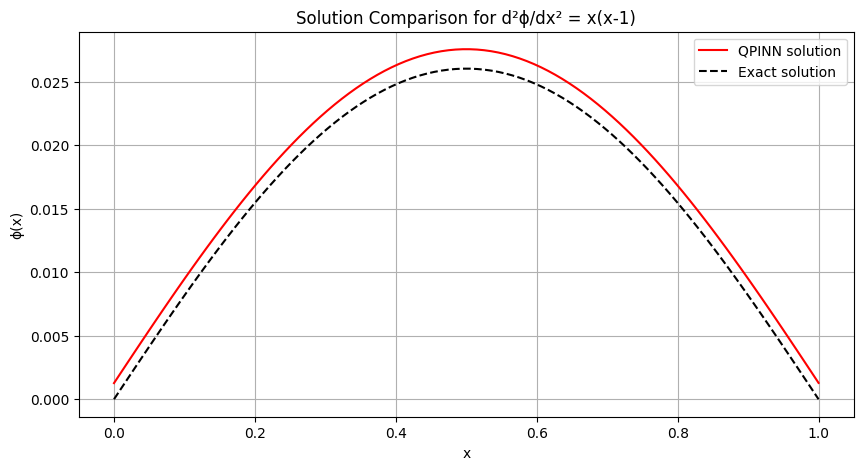

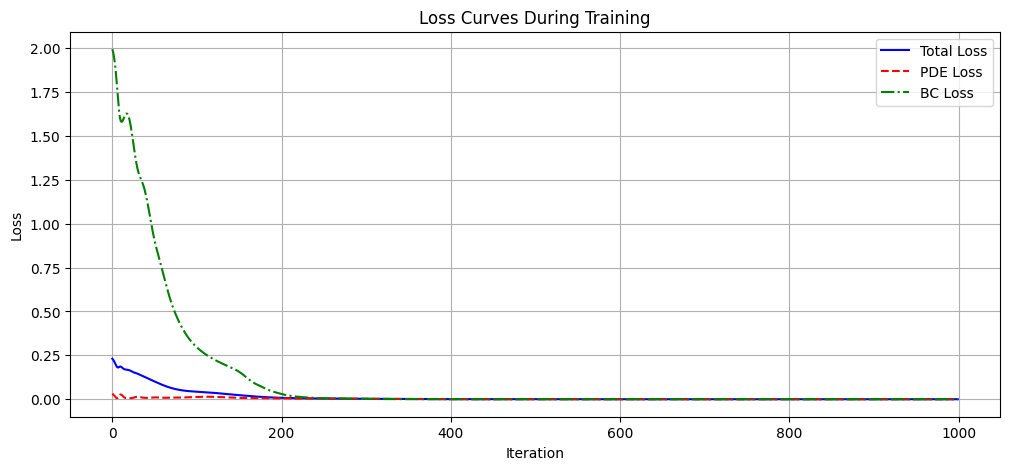

In [23]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# Hyperparameters
# ----------------------------------------------------------
num_qubits = 1               # Number of qubits in the quantum circuit
num_layers = 1               # Number of variational layers
learning_rate = 0.01         # Learning rate for the optimizer
num_iterations = 1000        # Number of training iterations
n_points = 100                # Number of training points in [0,1]

# ----------------------------------------------------------
# Create PennyLane device
# ----------------------------------------------------------
# Specify diff_method="backprop" to use PyTorch backpropagation
dev = qml.device("default.qubit", wires=num_qubits)

# ----------------------------------------------------------
# Quantum Circuit Definition
# ----------------------------------------------------------
@qml.qnode(dev, interface="torch", diff_method="backprop")
def quantum_model(params, x):
    """
    This QNode encodes the input x using a single RX rotation
    and applies several variational layers defined by params.
    The output is the expectation value of PauliZ on the qubit.
    
    Note:
    Instead of using AngleEmbedding (which may trigger an implicit numpy conversion),
    we encode x with an RX gate that remains differentiable.
    """
    # Data encoding with RX gate directly
    theta = x*(np.pi*2)
    idx = 0
    qml.RY(theta*params[idx], wires=0)
    idx += 1
    # Variational layers: each layer is a Rot gate (3 parameters per layer)
    for i in range(num_layers):
        qml.Rot(params[idx], params[idx+1], params[idx+2], wires=0)
        idx += 3
    # Measurement: return expectation value of PauliZ on qubit 0
    return qml.expval(qml.PauliZ(0))

# ----------------------------------------------------------
# Define a PyTorch Module wrapping the QNode
# ----------------------------------------------------------
class QPINN(nn.Module):
    def __init__(self, num_layers):
        super(QPINN, self).__init__()
        # We have 3 parameters per layer for the Rot gates
        self.num_params = 3 * num_layers + 1
        # Initialize parameters with a small random initialization
        init_params = 0.01 * torch.randn(self.num_params)
        self.params = nn.Parameter(init_params)

    def forward(self, x):
        """
        Forward pass of the QPINN.
        x: Tensor of shape [batch_size]. The QNode is applied for each element.
        """
        # Ensure x is a 1D tensor
        x = x.view(-1)
        outputs = []
        for xi in x:
            # Pass xi directly as a tensor (remains differentiable)
            outputs.append(quantum_model(self.params, xi))
        return torch.stack(outputs)

# ----------------------------------------------------------
# Create the model instance
# ----------------------------------------------------------
model = QPINN(num_layers)

# ----------------------------------------------------------
# Physics-Informed Loss Construction
# ----------------------------------------------------------
def compute_pde_residual(phi_pred, x):
    """
    Computes the PDE residual for d^2 phi/dx^2 - x*(x-1)=0.
    Uses PyTorch autograd to compute first and second derivatives.
    """
    # First derivative dphi/dx
    dphi_dx = torch.autograd.grad(
        phi_pred, x,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]
    # Second derivative d^2phi/dx^2
    d2phi_dx2 = torch.autograd.grad(
        dphi_dx, x,
        grad_outputs=torch.ones_like(dphi_dx),
        create_graph=True
    )[0]

    # PDE residual = d^2phi/dx^2 - x*(x-1)
    residual = d2phi_dx2 - x * (x - 1)
    return residual

def loss_function(x):
    """
    Computes the total loss as the sum of the PDE residual loss and
    the boundary condition (BC) losses.
    """
    # Enable gradient tracking for x (for second derivative calculation)
    x.requires_grad_(True)
    phi_pred = model(x)  # Predicted phi(x) from the QPINN

    # PDE residual loss: mean squared error of the residual
    residual = compute_pde_residual(phi_pred, x)
    pde_loss = torch.mean(residual**2)

    # Boundary conditions: phi(0)=0 and phi(1)=0 enforced by penalty terms
    bc0 = model(torch.tensor([0.0], dtype=x.dtype))
    bc1 = model(torch.tensor([1.0], dtype=x.dtype))
    bc_loss = bc0.pow(2).mean() + bc1.pow(2).mean()

    # Total loss is the sum of PDE residual loss and boundary condition loss
    total_loss = pde_loss + bc_loss * 0.1
    return total_loss, pde_loss, bc_loss

# ----------------------------------------------------------
# Training the Model
# ----------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create training points in the domain [0,1]
x_train = torch.linspace(0, 1, n_points, dtype=torch.float32)

# Lists to store loss values over iterations for plotting
total_loss_list = []
pde_loss_list = []
bc_loss_list = []

print("Starting training...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 50 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Total Loss: {total_loss_value.item():.6f}, "
              f"PDE Loss: {pde_loss_value.item():.6f}, BC Loss: {bc_loss_value.item():.6f}， c: {model.params[0]}:.6f")

print("Training finished.")

# ----------------------------------------------------------
# Evaluate the solution and compare with the exact solution
# ----------------------------------------------------------
# Create evaluation grid (no gradient needed for evaluation)
x_eval = torch.linspace(0, 1, 100, dtype=torch.float32)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    """Analytical solution: 1/12*(x - 2*x**3 + x**4)"""
    return (1.0/12.0) * (x - 2.0 * x**3 + x**4)

phi_exact_eval = exact_solution(x_eval)

# ----------------------------------------------------------
# Plot the learned solution vs. the exact solution
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(x_eval.cpu().numpy(), phi_pred_eval.cpu().numpy(), 'r-', label='QPINN solution')
plt.plot(x_eval.cpu().numpy(), phi_exact_eval.cpu().numpy(), 'k--', label='Exact solution')
plt.title("Solution Comparison for d²ϕ/dx² = x(x-1)")
plt.xlabel("x")
plt.ylabel("ϕ(x)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Plot the loss curves over training iterations
# ----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='Total Loss')
plt.plot(pde_loss_list, 'r--', label='PDE Loss')
plt.plot(bc_loss_list, 'g-.', label='BC Loss')
plt.title("Loss Curves During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
print(model.params[0]) 

tensor(-0.4754, grad_fn=<SelectBackward0>)


In [16]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# Hyperparameters
# ----------------------------------------------------------
num_qubits = 1               # Number of qubits in the quantum circuit
num_layers = 3               # Number of variational layers
learning_rate = 0.01         # Learning rate for the optimizer
num_iterations = 500         # Number of training iterations
n_points = 100               # Number of training points in [0,1]

# ----------------------------------------------------------
# Create PennyLane device
# ----------------------------------------------------------
# Specify diff_method="backprop" to use PyTorch backpropagation
dev = qml.device("default.qubit", wires=num_qubits)

# ----------------------------------------------------------
# Quantum Circuit Definition
# ----------------------------------------------------------
@qml.qnode(dev, interface="torch", diff_method="backprop")
def quantum_model(params, x):
    """
    This QNode encodes the input x using a single RY rotation
    and applies variational layers defined by params.
    The output is the expectation value of PauliZ on the qubit.
    
    Note:
    Instead of using AngleEmbedding (which may trigger an implicit numpy conversion),
    we encode x with an RY gate that remains differentiable.
    """
    theta = x * np.pi  # Data encoding: convert x to an angle in radians
    qml.RY(theta, wires=0)

    # Variational layers: each layer is a Rot gate (3 parameters per layer)
    idx = 0
    for i in range(num_layers):
        qml.Rot(params[idx], params[idx+1], params[idx+2], wires=0)
        idx += 3
    idx = 0
    for i in range(num_layers):
        qml.Rot(params[idx]*theta, params[idx+1]*theta, params[idx+2]*theta, wires=0)
        idx += 3

    # Measurement: return the expectation value of PauliZ on qubit 0
    return qml.expval(qml.PauliZ(0))

# ----------------------------------------------------------
# Define a PyTorch Module wrapping the QNode
# ----------------------------------------------------------
class QPINN(nn.Module):
    def __init__(self, num_layers):
        super(QPINN, self).__init__()
        # We have 3 parameters per layer for the Rot gates
        self.num_params = 3 * num_layers
        # Initialize parameters with a small random initialization
        init_params = 0.01 * torch.randn(self.num_params)
        self.params = nn.Parameter(init_params)

    def forward(self, x):
        """
        Forward pass of the QPINN.
        x: Tensor of shape [batch_size]. The QNode is applied for each element.
        """
        x = x.view(-1)
        outputs = []
        for xi in x:
            outputs.append(quantum_model(self.params, xi))
        return torch.stack(outputs)

# ----------------------------------------------------------
# Create the model instance
# ----------------------------------------------------------
model = QPINN(num_layers)

# ----------------------------------------------------------
# Physics-Informed Loss Construction
# ----------------------------------------------------------
def compute_pde_residual(phi_pred, x):
    """
    Computes the PDE residual for d^3 phi/dx^3 - x*(x-1)*(x-2)=0.
    Uses PyTorch autograd to compute derivatives up to third order.
    """
    # First derivative dphi/dx
    dphi_dx = torch.autograd.grad(
        phi_pred, x,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]
    # Second derivative d^2phi/dx^2
    d2phi_dx2 = torch.autograd.grad(
        dphi_dx, x,
        grad_outputs=torch.ones_like(dphi_dx),
        create_graph=True
    )[0]
    # Third derivative d^3phi/dx^3
    d3phi_dx3 = torch.autograd.grad(
        d2phi_dx2, x,
        grad_outputs=torch.ones_like(d2phi_dx2),
        create_graph=True
    )[0]

    # PDE residual: d^3phi/dx^3 - x*(x-1)*(x-2)
    residual = d3phi_dx3 - x * (x - 1) * (x - 2)
    return residual

def loss_function(x):
    """
    Computes the total loss as the sum of the PDE residual loss and
    the boundary condition (BC) losses.
    Boundary conditions are:
       phi(0) = 0, phi(1) = 0, and phi'(0) = 0.
    """
    # Enable gradient tracking for x (for third derivative calculation)
    x.requires_grad_(True)
    phi_pred = model(x)  # Predicted phi(x) from the QPINN

    # PDE residual loss: mean squared error of the residual
    residual = compute_pde_residual(phi_pred, x)
    pde_loss = torch.mean(residual**2)

    # Boundary conditions:
    # phi(0)=0 and phi(1)=0
    bc0 = model(torch.tensor([0.0], dtype=x.dtype))
    bc1 = model(torch.tensor([1.0], dtype=x.dtype))
    # phi'(0)=0: use an input with gradient tracking
    x0 = torch.tensor([0.0], dtype=x.dtype, requires_grad=True)
    phi0 = model(x0)
    bc2 = torch.autograd.grad(phi0, x0,
                              grad_outputs=torch.ones_like(phi0),
                              create_graph=True)[0]

    # BC loss as the sum of squares (with a weighting factor)
    bc_loss = bc0.pow(2).mean() + bc1.pow(2).mean() + bc2.pow(2).mean()

    # Total loss is the sum of PDE residual loss and the BC loss (weighted)
    total_loss = pde_loss + bc_loss
    return total_loss, pde_loss, bc_loss

# ----------------------------------------------------------
# Training the Model
# ----------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create training points in the domain [0,1]
x_train = torch.linspace(0, 1, n_points, dtype=torch.float32)

# Lists to store loss values over iterations for plotting
total_loss_list = []
pde_loss_list = []
bc_loss_list = []

print("Starting training...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 50 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Total Loss: {total_loss_value.item():.6f}, "
              f"PDE Loss: {pde_loss_value.item():.6f}, BC Loss: {bc_loss_value.item():.6f}")

print("Training finished.")

# ----------------------------------------------------------
# Evaluate the solution and compare with the exact solution
# ----------------------------------------------------------
# Create evaluation grid (no gradient needed for evaluation)
x_eval = torch.linspace(0, 1, 100, dtype=torch.float32)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    """
    Analytical solution for:
         d^3 phi/dx^3 = x(x-1)(x-2)
    with boundary conditions:
         phi(0)=0, phi'(0)=0, phi(1)=0.
    The solution is:
         phi(x) = x^6/120 - x^5/20 + x^4/12 - x^2/24.
    """
    return (1.0/120.0)*x**6 - (1.0/20.0)*x**5 + (1.0/12.0)*x**4 - (1.0/24.0)*x**2

phi_exact_eval = exact_solution(x_eval)

# ----------------------------------------------------------
# Plot the learned solution vs. the exact solution
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(x_eval.cpu().numpy(), phi_pred_eval.cpu().numpy(), 'r-', label='QPINN solution')
plt.plot(x_eval.cpu().numpy(), phi_exact_eval.cpu().numpy(), 'k--', label='Exact solution')
plt.title("Solution Comparison for d³ϕ/dx³ = x(x-1)(x-2)")
plt.xlabel("x")
plt.ylabel("ϕ(x)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Plot the loss curves over training iterations
# ----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='Total Loss')
plt.plot(pde_loss_list, 'r--', label='PDE Loss')
plt.plot(bc_loss_list, 'g-.', label='BC Loss')
plt.title("Loss Curves During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Starting training...


KeyboardInterrupt: 

开始训练...
迭代 50/500, 总损失: 0.583498, PDE损失: 0.498725, 边界损失: 0.847731
迭代 100/500, 总损失: 0.526751, PDE损失: 0.495837, 边界损失: 0.309137
迭代 150/500, 总损失: 0.497721, PDE损失: 0.495020, 边界损失: 0.027010
迭代 200/500, 总损失: 0.495055, PDE损失: 0.495000, 边界损失: 0.000553
迭代 250/500, 总损失: 0.495000, PDE损失: 0.495000, 边界损失: 0.000002
迭代 300/500, 总损失: 0.495000, PDE损失: 0.495000, 边界损失: 0.000000
迭代 350/500, 总损失: 0.495000, PDE损失: 0.495000, 边界损失: 0.000000
迭代 400/500, 总损失: 0.495000, PDE损失: 0.495000, 边界损失: 0.000000
迭代 450/500, 总损失: 0.495000, PDE损失: 0.495000, 边界损失: 0.000000
迭代 500/500, 总损失: 0.495000, PDE损失: 0.495000, 边界损失: 0.000000
训练完成.


/Users/letao/anaconda3/envs/M2_internship_QPINN/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/letao/anaconda3/envs/M2_internship_QPINN/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/letao/anaconda3/envs/M2_internship_QPINN/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/letao/anaconda3/envs/M2_internship_QPINN/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36739 (\N{CJK UNIFIED IDEOGRAPH-8F83}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/letao/anaconda3/envs/

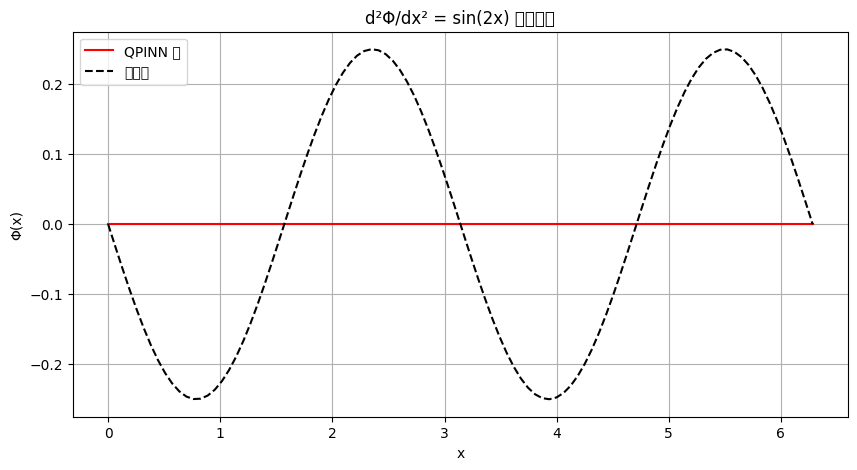

/Users/letao/anaconda3/envs/M2_internship_QPINN/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/letao/anaconda3/envs/M2_internship_QPINN/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/letao/anaconda3/envs/M2_internship_QPINN/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/letao/anaconda3/envs/M2_internship_QPINN/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/letao/anaconda3/envs/

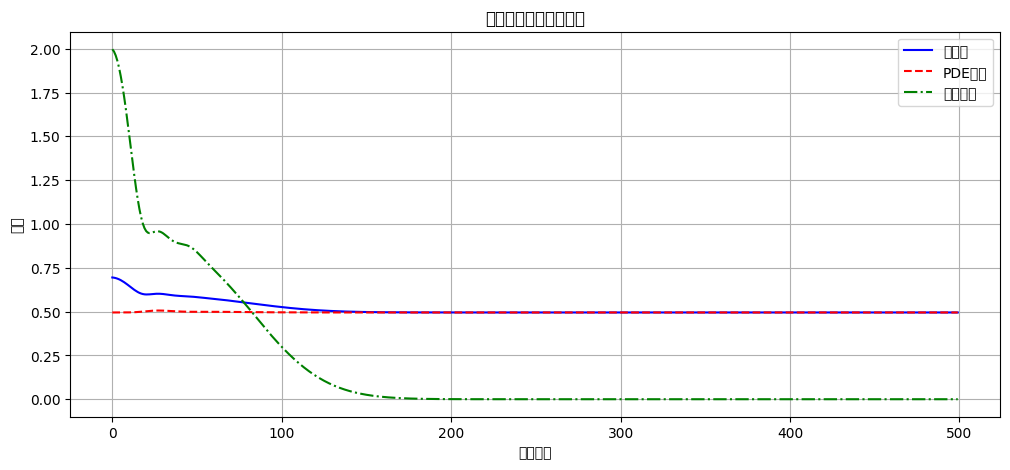

In [24]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 超参数设置
# ----------------------------------------------------------
num_qubits = 1                # 量子电路中使用的量子比特数
num_layers = 1                # 可变参数层数
learning_rate = 0.01          # 优化器学习率
num_iterations = 500          # 训练迭代次数
n_points = 100                # 在区间 [0, 2π] 内采样的训练点数

# ----------------------------------------------------------
# 创建 PennyLane 设备（默认的 qubit 模拟器）
# ----------------------------------------------------------
dev = qml.device("default.qubit", wires=num_qubits)

# ----------------------------------------------------------
# 量子电路定义
# ----------------------------------------------------------
@qml.qnode(dev, interface="torch", diff_method="backprop")
def quantum_model(params, x):
    """
    该 QNode 使用一个 RY 门对输入 x 进行编码，
    并利用若干个可变参数层（Rot 门）调整网络输出。
    输出为 qubit 0 的 PauliZ 期望值。
    """
    # 数据编码：由于 x 已在 [0, 2π] 内，直接使用
    theta = x
    idx = 0
    qml.RY(theta * params[idx], wires=0)
    idx += 1
    # 可变参数层，每层包含3个参数
    for i in range(num_layers):
        qml.Rot(params[idx], params[idx+1], params[idx+2], wires=0)
        idx += 3
    # 测量：返回 PauliZ 的期望值
    return qml.expval(qml.PauliZ(0))

# ----------------------------------------------------------
# 定义 QPINN 网络结构，封装 QNode
# ----------------------------------------------------------
class QPINN(nn.Module):
    def __init__(self, num_layers):
        super(QPINN, self).__init__()
        # 每层 Rot 门有 3 个参数，加上编码参数，总共 3*num_layers+1 个参数
        self.num_params = 3 * num_layers + 1
        init_params = 0.01 * torch.randn(self.num_params)
        self.params = nn.Parameter(init_params)

    def forward(self, x):
        # 确保 x 为 1D 张量
        x = x.view(-1)
        outputs = []
        for xi in x:
            outputs.append(quantum_model(self.params, xi))
        return torch.stack(outputs)

# ----------------------------------------------------------
# 创建 QPINN 模型实例
# ----------------------------------------------------------
model = QPINN(num_layers)

# ----------------------------------------------------------
# 构造物理信息损失函数（PDE残差以及边界条件）
# ----------------------------------------------------------
def compute_pde_residual(phi_pred, x):
    """
    计算 PDE 残差:
        d²Φ/dx² - sin(2x) = 0
    利用 PyTorch 的自动微分，先计算一阶再计算二阶导数
    """
    # 求一阶导数 dΦ/dx
    dphi_dx = torch.autograd.grad(
        phi_pred, x,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]
    # 求二阶导数 d²Φ/dx²
    d2phi_dx2 = torch.autograd.grad(
        dphi_dx, x,
        grad_outputs=torch.ones_like(dphi_dx),
        create_graph=True
    )[0]

    # PDE 残差定义为 d²Φ/dx² - sin(2x)
    residual = d2phi_dx2 - torch.sin(2 * x)
    return residual

def loss_function(x):
    """
    计算总损失：
      - PDE损失：残差的均方误差
      - 边界条件损失：使用罚函数确保 Φ(0)=0 和 Φ(2π)=0
    """
    x.requires_grad_(True)
    phi_pred = model(x)
    residual = compute_pde_residual(phi_pred, x)
    pde_loss = torch.mean(residual**2)

    # 边界条件：Φ(0) = 0 与 Φ(2π) = 0
    bc0 = model(torch.tensor([0.0], dtype=x.dtype))
    bc1 = model(torch.tensor([2 * np.pi], dtype=x.dtype))
    bc_loss = bc0.pow(2).mean() + bc1.pow(2).mean()

    total_loss = pde_loss + bc_loss * 0.1  # 可根据需要调整边界条件权重
    return total_loss, pde_loss, bc_loss

# ----------------------------------------------------------
# 模型训练
# ----------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 在 [0, 2π] 区间内生成训练数据
x_train = torch.linspace(0, 2 * np.pi, n_points, dtype=torch.float32)

total_loss_list = []
pde_loss_list = []
bc_loss_list = []

print("开始训练...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 50 == 0:
        print(f"迭代 {i+1}/{num_iterations}, 总损失: {total_loss_value.item():.6f}, "
              f"PDE损失: {pde_loss_value.item():.6f}, 边界损失: {bc_loss_value.item():.6f}")

print("训练完成.")

# ----------------------------------------------------------
# 模型评估及解的比较
# ----------------------------------------------------------
# 生成用于评估的网格数据
x_eval = torch.linspace(0, 2 * np.pi, 100, dtype=torch.float32)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    """
    精确解:
      Φ(x) = -1/4 * sin(2x)
    """
    return -0.25 * torch.sin(2 * x)

phi_exact_eval = exact_solution(x_eval)

# ----------------------------------------------------------
# 绘制 QPINN 解与精确解的比较图
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(x_eval.cpu().numpy(), phi_pred_eval.cpu().numpy(), 'r-', label='QPINN 解')
plt.plot(x_eval.cpu().numpy(), phi_exact_eval.cpu().numpy(), 'k--', label='精确解')
plt.title("d²Φ/dx² = sin(2x) 的解比较")
plt.xlabel("x")
plt.ylabel("Φ(x)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# 绘制训练过程中的损失曲线
# ----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='总损失')
plt.plot(pde_loss_list, 'r--', label='PDE损失')
plt.plot(bc_loss_list, 'g-.', label='边界损失')
plt.title("训练过程中的损失曲线")
plt.xlabel("迭代次数")
plt.ylabel("损失")
plt.legend()
plt.grid(True)
plt.show()
